In [60]:
import ROOT, os, math, sys
import scipy.optimize


def is_inside_ellipse(x1, y1, r1, r2, x, y):
    dist_x = (x - x1) ** 2 / r1 ** 2
    dist_y = (y - y1) ** 2 / r2 ** 2
    dist = math.sqrt(dist_x + dist_y)
    return dist < 1
    
def integrate_inside_ellipse(h, e):
    integral = 0
    x1 = e.GetX1()
    y1 = e.GetY1()
    r1 = e.GetR1()
    r2 = e.GetR2()
    for xbin in range(1, h.GetNbinsX() + 1):
        for ybin in range(1, h.GetNbinsY() + 1):
            bin_center_x = h.GetXaxis().GetBinCenter(xbin)
            bin_center_y = h.GetYaxis().GetBinCenter(ybin)
            # print(xbin, ybin, " ", bin_center_x, bin_center_y)
            
            if is_inside_ellipse(x1, y1, r1, r2, bin_center_x, bin_center_y):
                bin_content = h.GetBinContent(xbin, ybin)
                integral += bin_content
    return integral


In [61]:
hist_sum_zbbhtt = None
hist_sum_ztthbb = None
hist_sum_zzbbtt = None

for year in ["2016", "2016_HIPM", "2017", "2018"]:
    for analysis in ["ZttHbb", "ZbbHtt", "ZZ"]:
        FileName_sig = f"/grid_mnt/data__data.polcms/cms/{'vernazza' if analysis == 'ZZ' else 'cuisset'}/cmt/FeaturePlot2D/ul_{year}_{analysis}_v12/cat_base/prod_240318/root/{'H' if analysis == 'ZbbHtt' else 'Z'}tt_svfit_mass_ellipse_{'H' if analysis == 'ZttHbb' else 'Z'}bb_mass_ellipse__pg_{'zz_res_sig_vs_bkg' if analysis == 'ZZ' else 'zh_sig_vs_bkg'}__nodata.root"
        tf_sig = ROOT.TFile.Open(FileName_sig)
        dir = tf_sig.Get("histograms")
        dir.cd()
        if analysis == "ZZ":
            signal = "zz_sl_signal"
            h_sig_zzbbtt = dir.Get(signal).Clone()
            if hist_sum_zzbbtt is None: 
                hist_sum_zzbbtt = h_sig_zzbbtt.Clone("hist_sum_zzbbtt")
                hist_sum_zzbbtt.SetDirectory(0)
            else:
                hist_sum_zzbbtt.Add(h_sig_zzbbtt)
        elif analysis == "ZbbHtt":
            signal = "zh_zbb_htt_signal"
            h_sig_zbbhtt = dir.Get(signal).Clone()
            if hist_sum_zbbhtt is None: 
                hist_sum_zbbhtt = h_sig_zbbhtt.Clone("hist_sum_zbbhtt")
                hist_sum_zbbhtt.SetDirectory(0)
            else:
                hist_sum_zbbhtt.Add(h_sig_zbbhtt)
        elif analysis == "ZttHbb":
            signal = "zh_ztt_hbb_signal"
            h_sig_ztthbb = dir.Get(signal).Clone()
            if hist_sum_ztthbb is None:
                hist_sum_ztthbb = h_sig_ztthbb.Clone("hist_sum_ztthbb")
                hist_sum_ztthbb.SetDirectory(0)
            else:
                hist_sum_ztthbb.Add(h_sig_ztthbb)
        tf_sig.Close()

# Zbb Htt

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


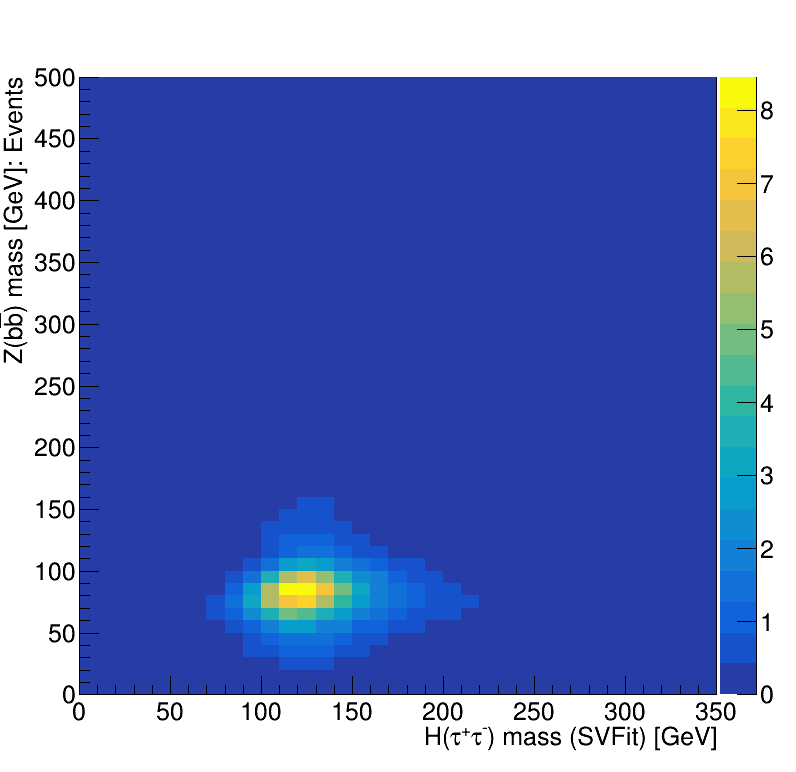

In [62]:
c1 = ROOT.TCanvas("c1", "", 800, 800)
c1.cd()
hist_sum_zbbhtt.Draw("COLZ")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3


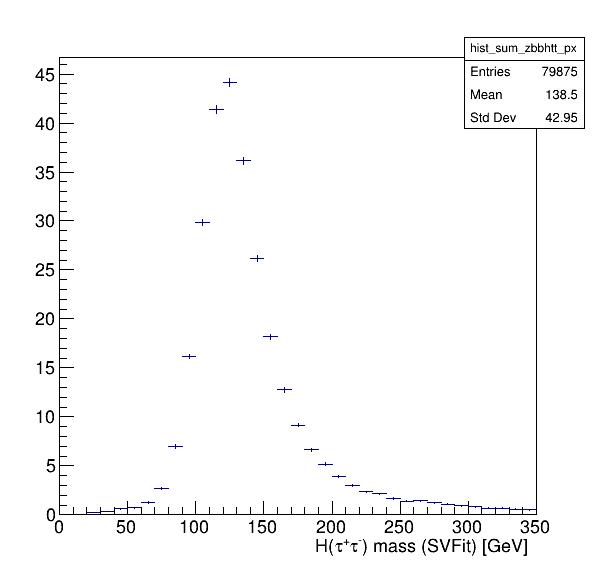

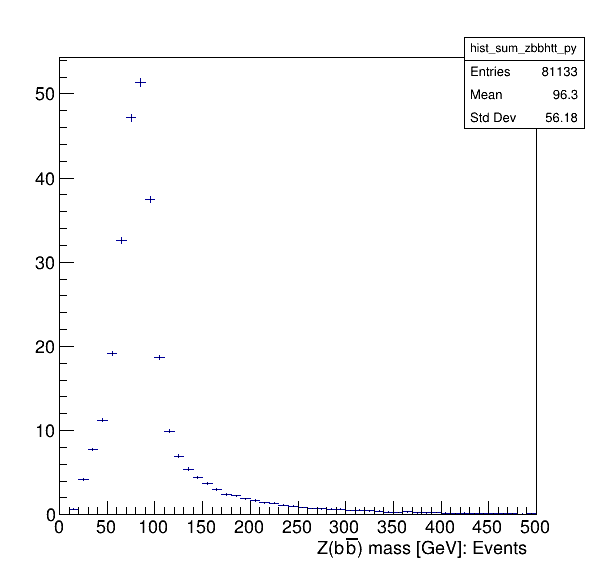

In [63]:
hist_htt = hist_sum_zbbhtt.ProjectionX()
c2 = ROOT.TCanvas("c2", "", 600, 600)
c2.cd()
hist_htt.Draw()
c2.Draw()

hist_zbb = hist_sum_zbbhtt.ProjectionY()
c3 = ROOT.TCanvas("c3", "", 600, 600)
c3.cd()
hist_zbb.Draw()
c3.Draw()

H_tautau maximum = 125.0, H_tautau sigma = 42.95243654882645
Z_bb maximum = 85.0, Z_bb sigma = 56.17843646228657
Efficiency target : 0.9 >>>>> alpha = 2.3333007812500006, actual efficiency = 0.8998222055952424
Ellipse Coordinates : X = 125.0, R1 = 100.22095375596783, Y = 85.0, R2 = 131.08118968685676


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4


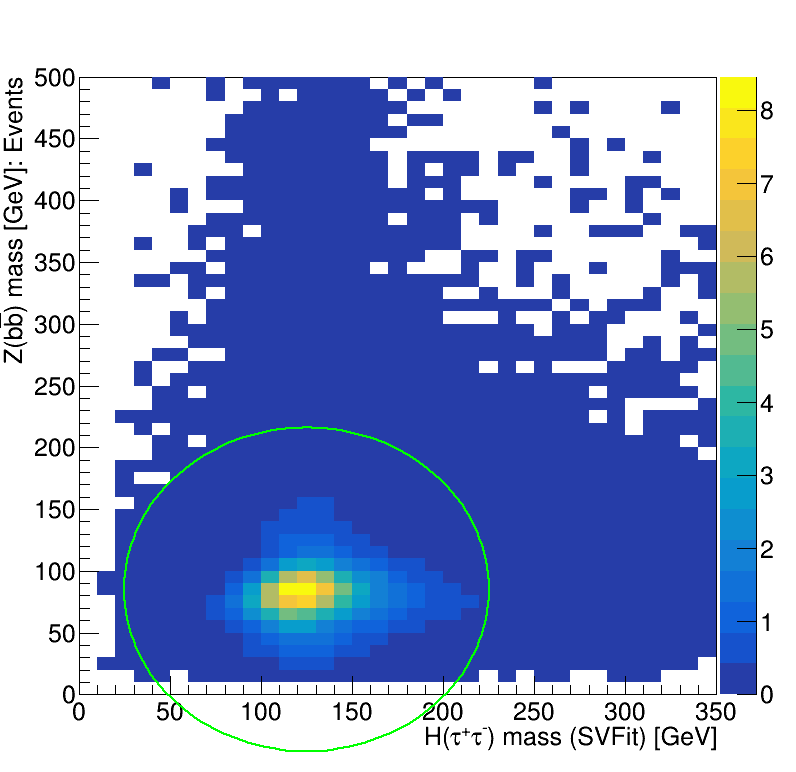

In [64]:
htt_c = hist_htt.GetXaxis().GetBinCenter(hist_htt.GetMaximumBin())
htt_s = hist_htt.GetStdDev()

zbb_c = hist_zbb.GetXaxis().GetBinCenter(hist_zbb.GetMaximumBin())
zbb_s = hist_zbb.GetStdDev()

print(f"H_tautau maximum = {htt_c}, H_tautau sigma = {htt_s}")
print(f"Z_bb maximum = {zbb_c}, Z_bb sigma = {zbb_s}")

def computeSigEff(alpha):
        e = ROOT.TEllipse(htt_c, zbb_c, alpha*htt_s, alpha*zbb_s)
        return integrate_inside_ellipse(hist_sum_zbbhtt, e) / hist_sum_zbbhtt.Integral()

efficiency_target = 0.9

alpha_best = scipy.optimize.bisect(lambda alpha: computeSigEff(alpha) - efficiency_target, 0.1, 10, xtol=0.01)

Best_E = ROOT.TEllipse(htt_c, zbb_c, alpha_best*htt_s, alpha_best*zbb_s)

print(f"Efficiency target : {efficiency_target} >>>>> alpha = {alpha_best}, actual efficiency = {computeSigEff(alpha_best)}")
print(f"Ellipse Coordinates : X = {htt_c}, R1 = {alpha_best*htt_s}, Y = {zbb_c}, R2 = {alpha_best*zbb_s}")

c4 = ROOT.TCanvas("c4", "", 800, 800)
c4.cd()
hist_sum_zbbhtt.Draw("COLZ")
Best_E.SetFillStyle(0)
Best_E.SetFillColorAlpha(0, 0)
Best_E.SetLineWidth(2)
Best_E.SetLineColor(ROOT.kGreen)
Best_E.Draw("SAME")
hist_sum_zbbhtt.SetMinimum(0.)
c4.Draw()

# Ztt Hbb

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


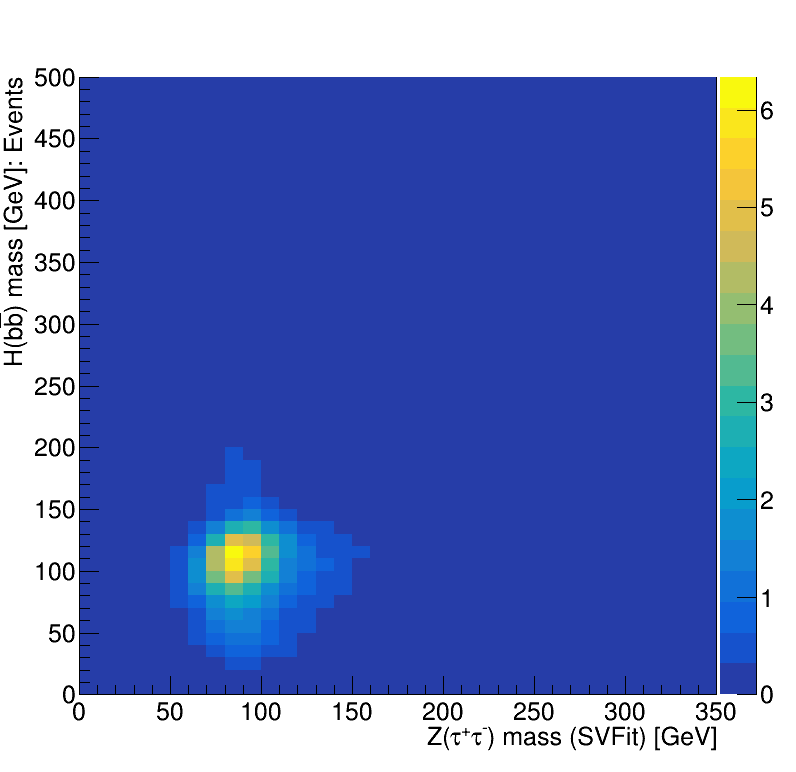

In [65]:
c1 = ROOT.TCanvas("c1", "", 800, 800)
c1.cd()
hist_sum_ztthbb.Draw("COLZ")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3


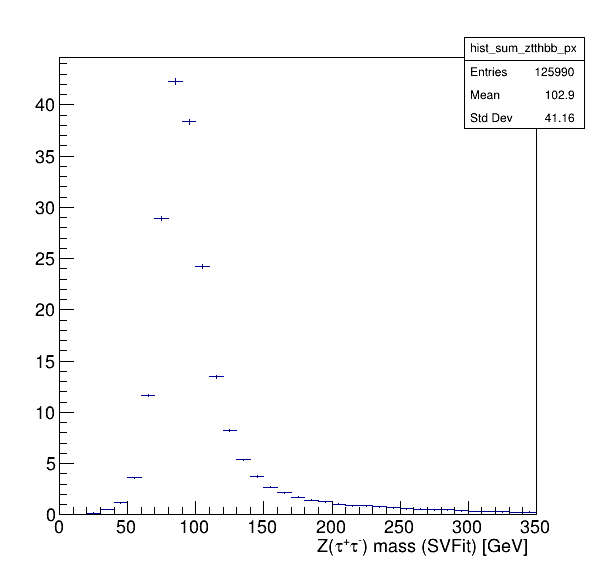

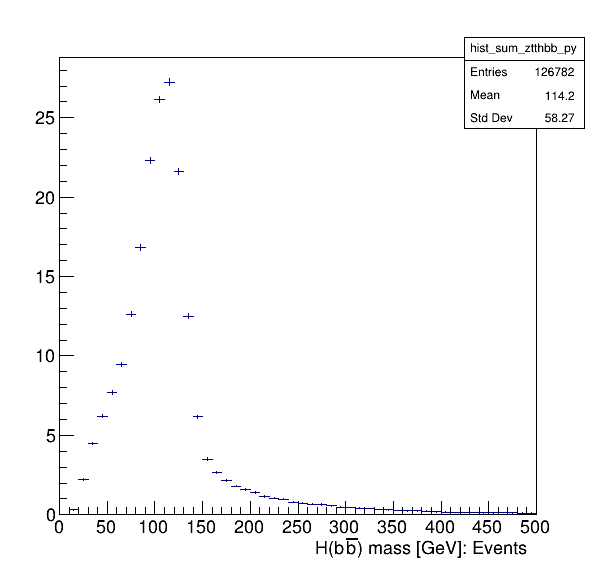

In [66]:
hist_ztt = hist_sum_ztthbb.ProjectionX()
c2 = ROOT.TCanvas("c2", "", 600, 600)
c2.cd()
hist_ztt.Draw()
c2.Draw()

hist_hbb = hist_sum_ztthbb.ProjectionY()
c3 = ROOT.TCanvas("c3", "", 600, 600)
c3.cd()
hist_hbb.Draw()
c3.Draw()

Z_tautau maximum = 85.0, Z_tautau sigma = 41.16228223176387
H_bb maximum = 115.0, H_bb sigma = 58.27292545417802
Efficiency target : 0.9 >>>>> alpha = 2.23662109375, actual efficiency = 0.9003067310118392
Ellipse Coordinates : X = 85.0, R1 = 92.0644287064539, Y = 115.0, R2 = 130.33445426533586


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4


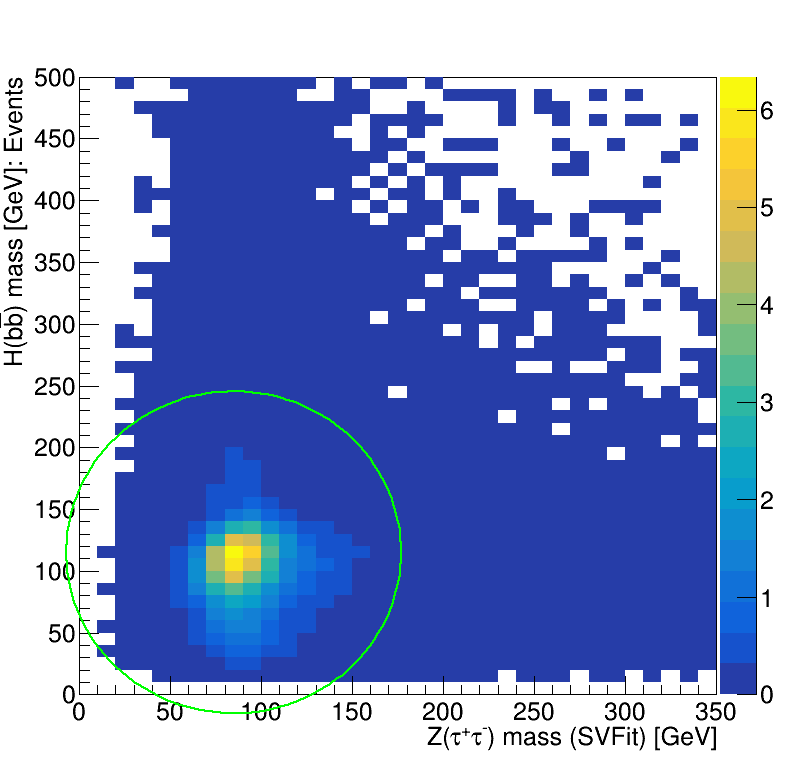

In [67]:
ztt_c = hist_ztt.GetXaxis().GetBinCenter(hist_ztt.GetMaximumBin())
ztt_s = hist_ztt.GetStdDev()

hbb_c = hist_hbb.GetXaxis().GetBinCenter(hist_hbb.GetMaximumBin())
hbb_s = hist_hbb.GetStdDev()

print(f"Z_tautau maximum = {ztt_c}, Z_tautau sigma = {ztt_s}")
print(f"H_bb maximum = {hbb_c}, H_bb sigma = {hbb_s}")

def computeSigEff(alpha):
        e = ROOT.TEllipse(ztt_c, hbb_c, alpha*ztt_s, alpha*hbb_s)
        return integrate_inside_ellipse(hist_sum_ztthbb, e) / hist_sum_ztthbb.Integral()

efficiency_target = 0.9

alpha_best = scipy.optimize.bisect(lambda alpha: computeSigEff(alpha) - efficiency_target, 0.1, 10, xtol=0.01)

Best_E = ROOT.TEllipse(ztt_c, hbb_c, alpha_best*ztt_s, alpha_best*hbb_s)

print(f"Efficiency target : {efficiency_target} >>>>> alpha = {alpha_best}, actual efficiency = {computeSigEff(alpha_best)}")
print(f"Ellipse Coordinates : X = {ztt_c}, R1 = {alpha_best*ztt_s}, Y = {hbb_c}, R2 = {alpha_best*hbb_s}")

c4 = ROOT.TCanvas("c4", "", 800, 800)
c4.cd()
hist_sum_ztthbb.Draw("COLZ")
Best_E.SetFillStyle(0)
Best_E.SetFillColorAlpha(0, 0)
Best_E.SetLineWidth(2)
Best_E.SetLineColor(ROOT.kGreen)
Best_E.Draw("SAME")
hist_sum_ztthbb.SetMinimum(0.)
c4.Draw()

# ZZbbtt

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


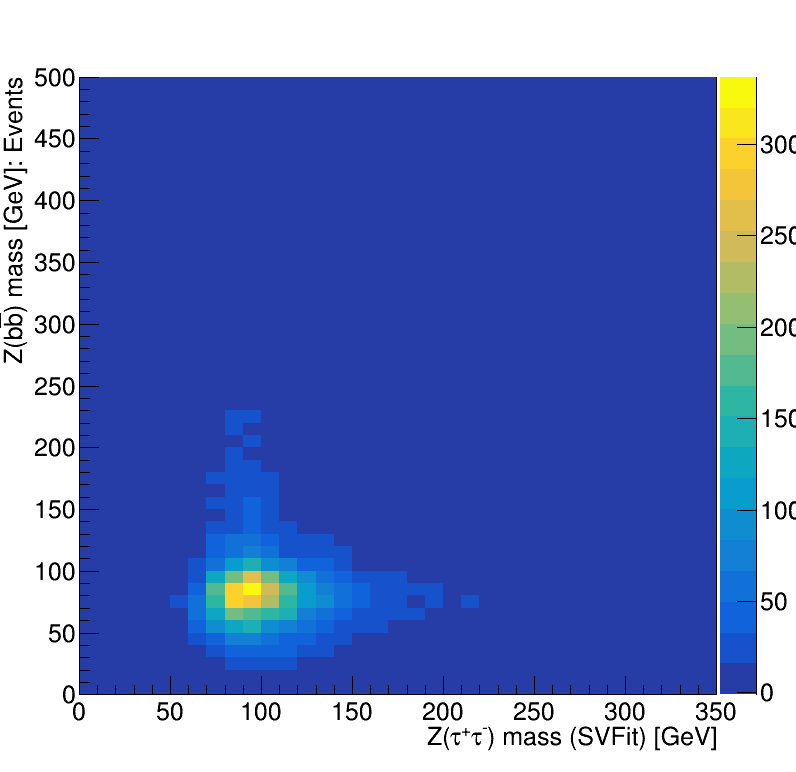

In [68]:
c1 = ROOT.TCanvas("c1", "", 800, 800)
c1.cd()
hist_sum_zzbbtt.Draw("COLZ")
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c3


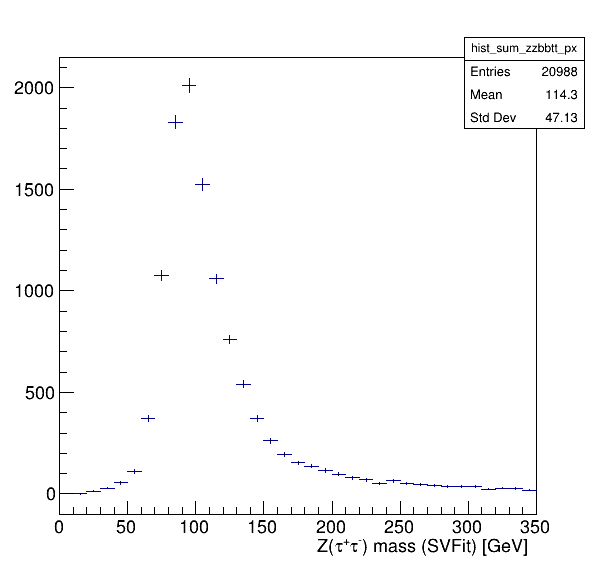

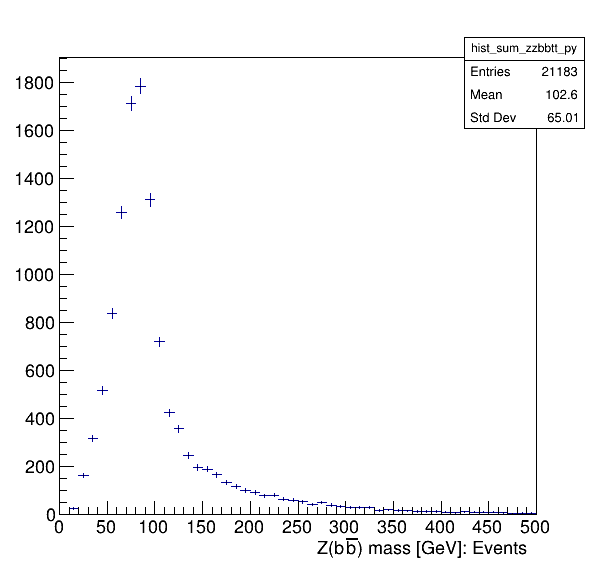

In [69]:
hist_ztt = hist_sum_zzbbtt.ProjectionX()
c2 = ROOT.TCanvas("c2", "", 600, 600)
c2.cd()
hist_ztt.Draw()
c2.Draw()

hist_zbb = hist_sum_zzbbtt.ProjectionY()
c3 = ROOT.TCanvas("c3", "", 600, 600)
c3.cd()
hist_zbb.Draw()
c3.Draw()

Z_tautau maximum = 95.0, Z_tautau sigma = 47.131768616291374
Z_bb maximum = 85.0, Z_bb sigma = 65.01282749857695
Efficiency target : 0.9 >>>>> alpha = 2.5459960937500004, actual efficiency = 0.90043261024426
Ellipse Coordinates : X = 95.0, R1 = 119.9972987886067, Y = 85.0, R2 = 165.52240485501954


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4


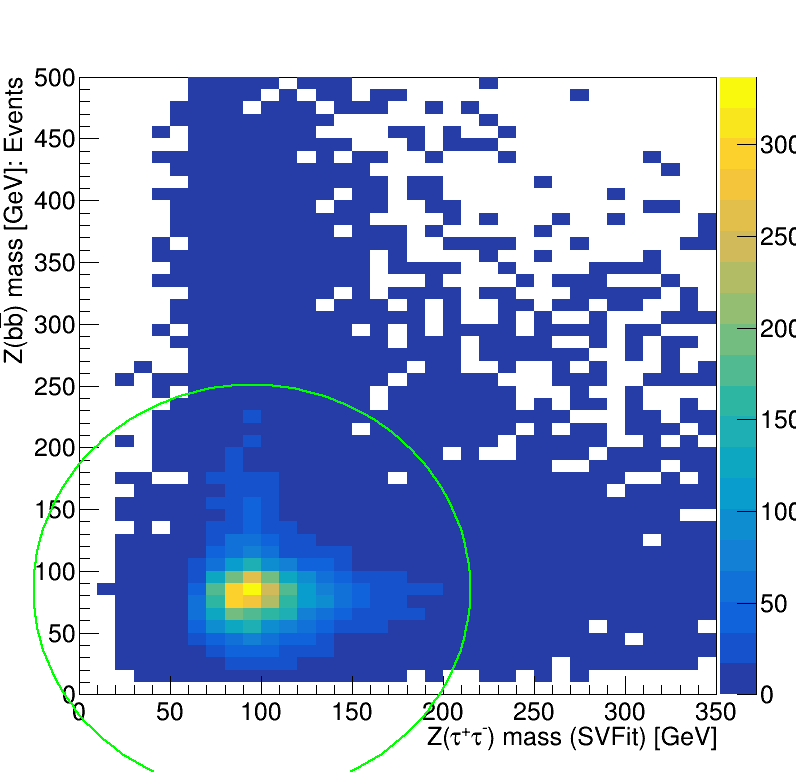

In [70]:
ztt_c = hist_ztt.GetXaxis().GetBinCenter(hist_ztt.GetMaximumBin())
ztt_s = hist_ztt.GetStdDev()

zbb_c = hist_zbb.GetXaxis().GetBinCenter(hist_zbb.GetMaximumBin())
zbb_s = hist_zbb.GetStdDev()

print(f"Z_tautau maximum = {ztt_c}, Z_tautau sigma = {ztt_s}")
print(f"Z_bb maximum = {zbb_c}, Z_bb sigma = {zbb_s}")

def computeSigEff(alpha):
        e = ROOT.TEllipse(ztt_c, zbb_c, alpha*ztt_s, alpha*zbb_s)
        return integrate_inside_ellipse(hist_sum_zzbbtt, e) / hist_sum_zzbbtt.Integral()

efficiency_target = 0.9

alpha_best = scipy.optimize.bisect(lambda alpha: computeSigEff(alpha) - efficiency_target, 0.1, 10, xtol=0.01)

Best_E = ROOT.TEllipse(ztt_c, zbb_c, alpha_best*ztt_s, alpha_best*zbb_s)

print(f"Efficiency target : {efficiency_target} >>>>> alpha = {alpha_best}, actual efficiency = {computeSigEff(alpha_best)}")
print(f"Ellipse Coordinates : X = {ztt_c}, R1 = {alpha_best*ztt_s}, Y = {zbb_c}, R2 = {alpha_best*zbb_s}")

c4 = ROOT.TCanvas("c4", "", 800, 800)
c4.cd()
hist_sum_zzbbtt.Draw("COLZ")
Best_E.SetFillStyle(0)
Best_E.SetFillColorAlpha(0, 0)
Best_E.SetLineWidth(2)
Best_E.SetLineColor(ROOT.kGreen)
Best_E.Draw("SAME")
hist_sum_zzbbtt.SetMinimum(0.)
c4.Draw()